<a href="https://colab.research.google.com/github/TuckerArrants/computer-vision/blob/master/melanoma-5fold-efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma Classification with TPUs

**This notebook is largely just a repurposing of [my kernel](https://www.kaggle.com/tuckerarrants/kfold-efficientnet-cutmix-mixup-tta) for the [Flowers](https://www.kaggle.com/c/tpu-getting-started) competition, adapted for binary classification and with competition specific metrics. I also added course dropout augmentation, taken from Chris Deotte's [starter](https://www.kaggle.com/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout); GridMask, taken from [here](https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow); and  removed CutMix/MixUp since it is hard to implement in this competition (more [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160784)). I tried to use AugMix, but was not having much sucess with it**

In [ ]:
#the basics
from matplotlib import pyplot as plt
import math, os, re, gc, cv2, random
import numpy as np, pandas as pd, seaborn as sns

#deep learning basics
import tensorflow as tf
import tensorflow.keras.backend as K

#get current TensorFlow version fo
print("Currently using Tensorflow version " + tf.__version__)

Currently using Tensorflow version 2.3.0


# I. Configuration

**To take advantage of TPUs, we have to do some extra work. For the uninitiated, [this](http://www.tensorflow.org/guide/tpu) is an excellent place to start. We start by checking to see if TensorFlow is using a TPU or not - if it isn't, we set the 'strategy' to its default, which works on CPU and a single GPU, though we will definitely need to use the TPU for the current parameter setups of this notebook**

In [ ]:
#choose device
DEVICE = 'TPU'

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.98.115.170:8470
initializing  TPU ...
INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


In [ ]:
#for reproducibility
SEED = 34 

#select image size             
IMAGE_SIZE = [256, 256]               

#how many training samples we want going to TPUs 
BATCH_SIZE = 32 * REPLICAS 

#how long are we training for?
EPOCHS = 15

#how many folds we will use to train our model on
FOLDS = 5

#upsample with external melanoma images (Deotte's)?
UPSAMPLE = False

#how many TTA steps to apply
#set to 0 for no TTA
TTA = 15   

#to see training progress or not
VERBOSE = 2

**TPUs read data directly from Google Cloud Storage (GCS), so we actually need to copy our dataset to a GCS 'bucket' that is near or 'co-located' with the TPU. The below chunk of code accomplishes this using the handy kaggle_datasets. We will be using [Chris Deotte](https://www.kaggle.com/cdeotte)'s TFRecords for both this year's images and also for upsampling images:** 

In [ ]:
#get GCS path for melanoma classification data set
#from kaggle_datasets import KaggleDatasets
#GCS_PATH = KaggleDatasets().get_gcs_path(f'melanoma-{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}')
#GCS_PATH2 = KaggleDatasets().get_gcs_path(f'malignant-v2-{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}')

GCS_PATH = 'gs://kds-70a7c4e5b6d829457f064a0dd311b9d7676eb5333e3507d14e549ddc'
GCS_PATH2 = 'gs://kds-c568853d1110d2d19d0ea9820854c4fdf0f415026ef02a06f5048fec'

In [ ]:
#can use this path in Google Colabs if you want to run notebook on TPU there instead
print(GCS_PATH)
print(GCS_PATH2)

gs://kds-70a7c4e5b6d829457f064a0dd311b9d7676eb5333e3507d14e549ddc
gs://kds-c568853d1110d2d19d0ea9820854c4fdf0f415026ef02a06f5048fec


**Now we need to create some functions that allow us to extract information from these `TFRecords`. We will create functions that read the image and label from the `TFRecords`. For more about this, see [here](http://www.tensorflow.org/tutorials/load_data/tfrecord)**

**We can also perform some easy augmentations to be used during training and also for test time augmentation. For a quick reference on using `tf.image` to perform image augmentation, see [this](http://www.tensorflow.org/tutorials/images/data_augmentation)**

**To achieve peak performance, we can use a pipeline that 'prefetches' data for the next step before the current step has finished using `tf.data`. You can learn more [here](http://www.tensorflow.org/guide/data_performance)**

In [ ]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name = True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def prepare_image(img, dim, course_drop = False, grid_mask = False, mat_aug = False, all_aug = False,
                  droprate = .7, dropct = 8, dropsize = .2):
    
    #decode image
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    #apply course dropout augmentation
    if course_drop:
        
        #flipping augmentations - can apply before or after course dropout function
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        #some other easy transformations we can apply
        #img = tf.image.random_hue(img, 0.01)
        #img = tf.image.random_saturation(img, 0.7, 1.3)
        #img = tf.image.random_contrast(img, 0.8, 1.2)
        #img = tf.image.random_brightness(img, 0.1)
        
        if (droprate!=0)&(dropct!=0)&(dropsize!=0): 
            img = dropout(img, DIM = dim, PROBABILITY = droprate, CT = dropct, SZ = dropsize)
    
    #apply shear/shift/zoom augmentation
    if mat_aug: 
        
        #flipping augmentations - can apply before or after transform function
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        #some other easy transformations we can apply
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        #img = tf.image.random_contrast(img, 0.8, 1.2)
        #img = tf.image.random_brightness(img, 0.1)
        
        img = transform(img,DIM=dim)
     
    #apply grid mask augmentation
    if grid_mask:
        
        #flipping augmentations - can apply before or after grid mask function
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        #some other easy transformations we can apply
        #img = tf.image.random_hue(img, 0.01)
        #img = tf.image.random_saturation(img, 0.7, 1.3)
        #img = tf.image.random_contrast(img, 0.8, 1.2)
        #img = tf.image.random_brightness(img, 0.1)\
        
        img = apply_grid_mask(img, (dim, dim, 3))
        
    #apply combination of all the above
    if all_aug:
        
        #flipping augmentations - can apply before or after grid mask function
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        #some other easy transformations we can apply
        #img = tf.image.random_hue(img, 0.01)
        #img = tf.image.random_saturation(img, 0.7, 1.3)
        #img = tf.image.random_contrast(img, 0.8, 1.2)
        #img = tf.image.random_brightness(img, 0.1)\
        
        img = apply_all_aug(img, DIM = dim)

    #reshape so TPU knows size of image                 
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [ ]:
#define pre fetching strategy
AUTO = tf.data.experimental.AUTOTUNE

#use tf.io.gfile.glob to find our training and test files from GCS bucket
train_files = np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'))
test_files  = np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec'))
    
#show item counts
NUM_TRAINING_IMAGES = int( count_data_items(train_files) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(train_files) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(test_files)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 26153 training images, 6538 validation images, 10982 unlabeled test images


In [ ]:
def get_dataset(files, course_drop = False, grid_mask = False, mat_aug = False, all_aug = False, shuffle = False,
                repeat = False, labeled = True, return_image_names = True, batch_size = BATCH_SIZE, dim = IMAGE_SIZE[0]):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(2048)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)   
        
    ds = ds.map(lambda img, imgname_or_label: (
                prepare_image(img, course_drop = course_drop, grid_mask = grid_mask ,mat_aug = mat_aug,
                              all_aug = all_aug, dim=dim,), imgname_or_label), num_parallel_calls = AUTO)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTO)
    return ds

# II. Visualization

**Now that we have dealt with all the configuring required to use TPUs, we can extract our images from the TPU and finally get a look at our data:**

In [ ]:
#define classes for labeling purposes
classes = ['benign', 'malignant']

**Define some helper functions to plot our melanoma images:**

In [ ]:
#numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #binary strings are image IDs
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    #If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return classes[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(classes[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                classes[correct_label] if not correct else ''), correct

def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    #auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    #size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    #display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else classes[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_image(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #get optimal spacing
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
#first look at training dataset
training_dataset = get_dataset(train_files, labeled = True, course_drop = False, all_aug = False,
                               grid_mask = False, mat_aug = False, shuffle = True, repeat = True)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [ ]:
#first look at test dataset
test_dataset = get_dataset(test_files, labeled = False, course_drop = False, grid_mask = False,
                           mat_aug = False, all_aug = False, shuffle = True, repeat = False)
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

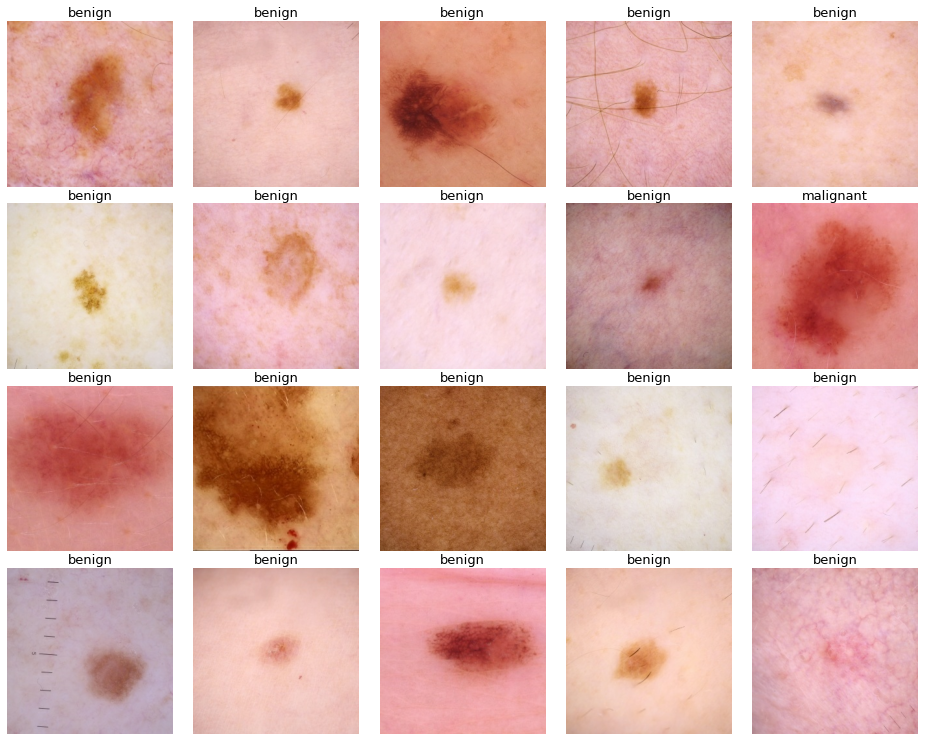

In [ ]:
#view batch of images from train
display_batch_of_images(next(train_batch))
#you can run this cell again and it will load a new batch

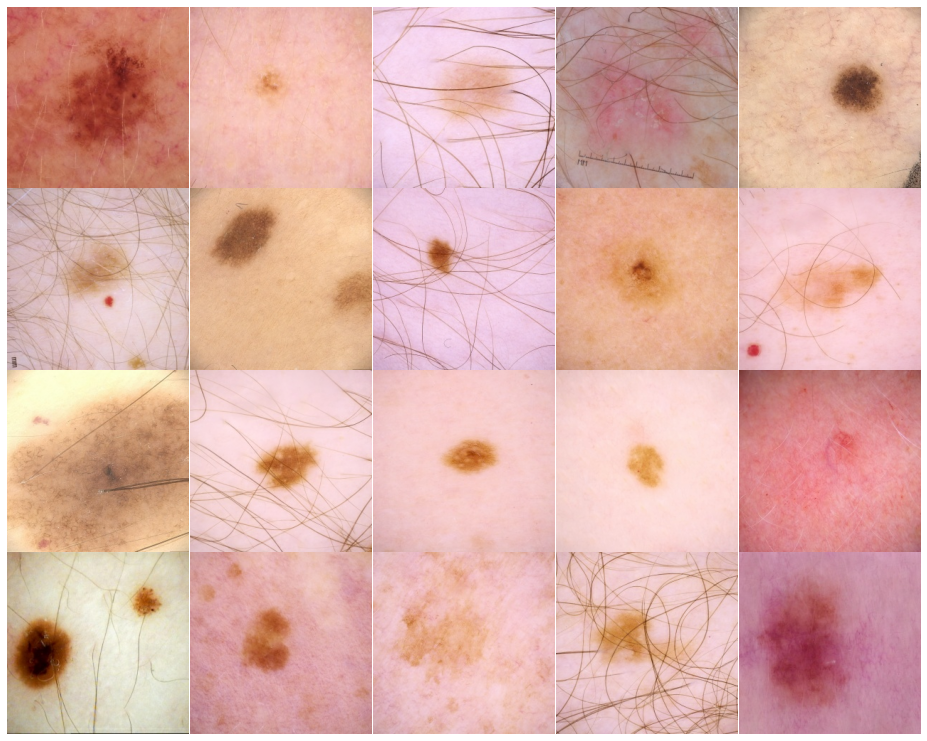

In [ ]:
#view batch of images from test
display_batch_of_images(next(test_batch))
#you can run this cell again and it will load a new batch

# III. Augmentation

**Note: the following augmentation implementations are taken from (4X Kaggle Grandmaster) [Chris Deotte](https://www.kaggle.com/cdeotte)'s notebook, which can be found [here](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords/data) and [here](https://www.kaggle.com/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout)**

### Rotation, Shift, Zoom, Shear

In [ ]:
ROT_ = 180.0; SHR_ = 2.0
HZOOM_ = 8.0; WZOOM_ = 8.0
HSHIFT_ = 8.0; WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):

    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    

    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

In [ ]:
def transform(image, DIM=256):    
    
    XDIM = DIM%2 
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )

    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
              
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

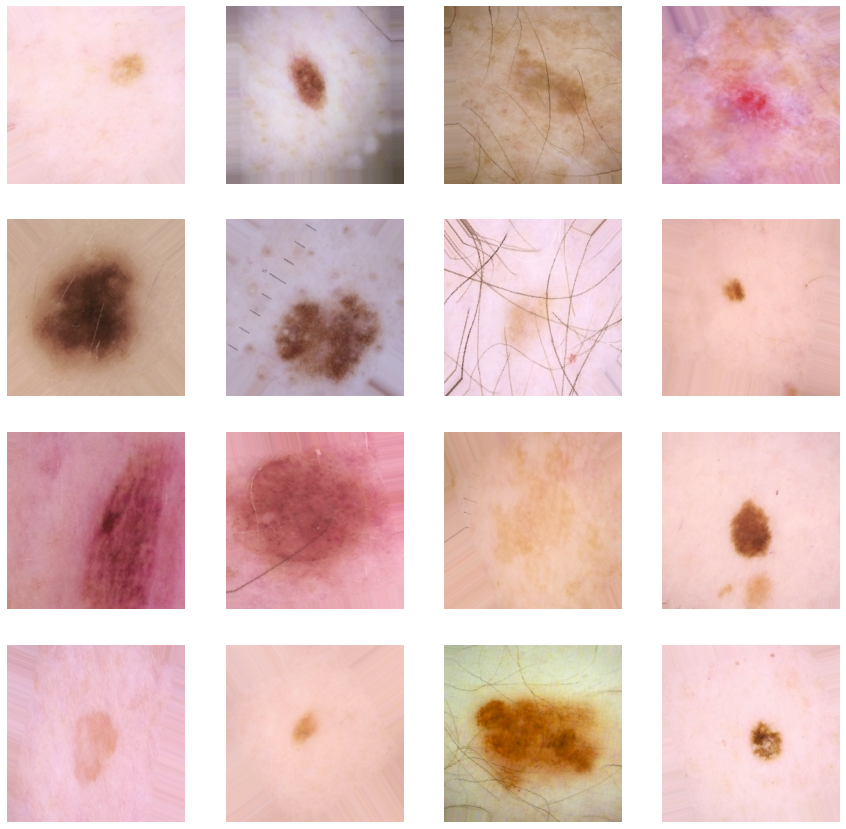

In [ ]:
#view augmentation
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(train_files, labeled = True, mat_aug = True,
                           course_drop = False, shuffle = True, repeat = True)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

## Coarse Dropout

**Using MixUp/CutMix for this problem is a bit tricky as there are only two classes and only about 1.8% of samples are malignant. You can read more about the challenges [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160784) as explained by [Roman](https://www.kaggle.com/nroman)**

**We can instead resort to coarse dropout augmentation for online augmentation. Note that we have an option here: do we apply `transform` for augmentation or `dropout` and for what type of augmentation? You can easily experiment with either (or a combination of both) by changing the parameters of the `get_dataset` function earlier defined:**

In [ ]:
def dropout(image, DIM=256, PROBABILITY = 1, CT = 8, SZ = 0.2):
    
    prob = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (prob==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):

        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        WIDTH = tf.cast( SZ*DIM,tf.int32) * prob
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    image = tf.reshape(image,[DIM,DIM,3])
    return image

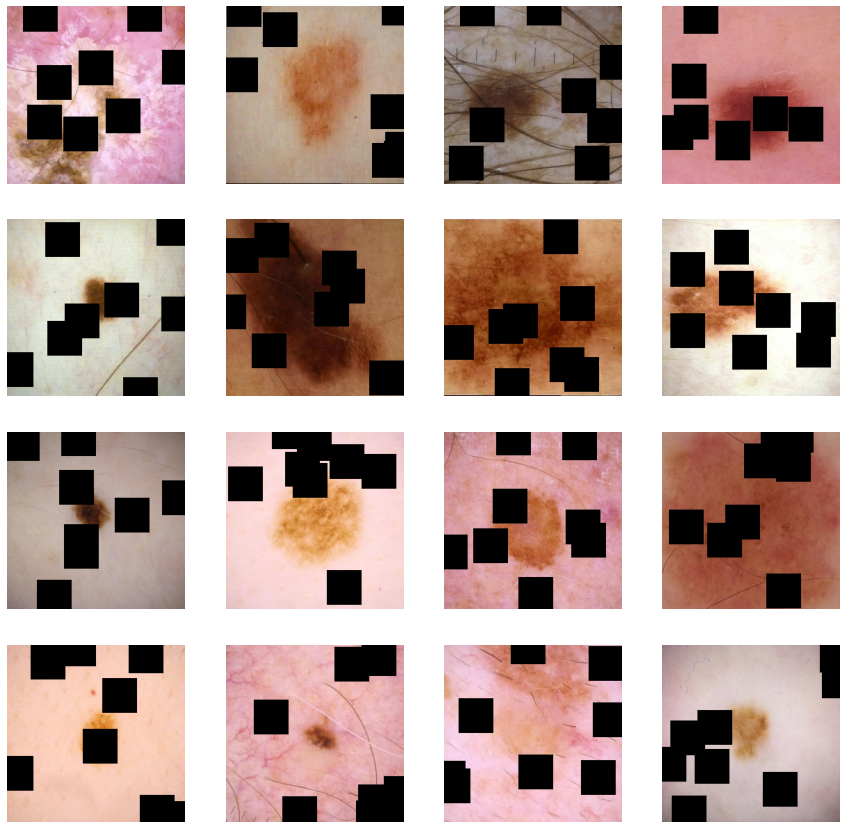

In [ ]:
#view what course dropout looks like
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(train_files, labeled = True,
                           course_drop = True, shuffle = True, repeat = True)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

## GridMask

**Now we can explore GridMask, which is essentially a less randomized Course Dropout The below code is taken from [this notebook](https://www.kaggle.com/xiejialun/gridmask-data-augmentation-with-tensorflow)**

In [ ]:
AugParams = {
    'd1' : 100,
    'd2': 160,
    'rotate' : 45,
    'ratio' : 0.4
}

In [ ]:
def transform2(image, inv_mat, image_shape):

    h, w, c = image_shape
    cx, cy = w//2, h//2

    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)

    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)

    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):

    def get_rotation_mat_inv(angle):
        #transform to radian
        angle = math.pi * angle / 180

        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)

        rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform2(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):

    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_grid_mask(image, image_shape = IMAGE_SIZE):
    mask = GridMask(image_shape[0],
                    image_shape[1],
                    AugParams['d1'],
                    AugParams['d2'],
                    AugParams['rotate'],
                    AugParams['ratio'])
    
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)

    return tf.cast(image * tf.cast(mask, tf.float32), tf.float32)

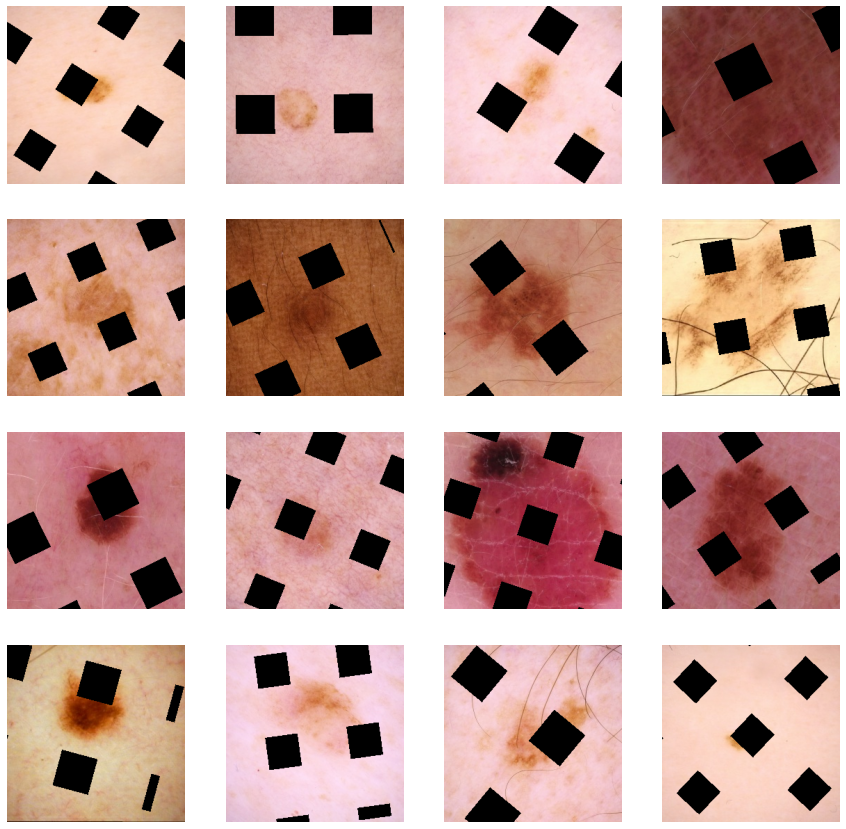

In [ ]:
#view what grid mask looks like
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(train_files, labeled = True, grid_mask = True, 
                           course_drop = False, shuffle = True, repeat = True)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

## All The Above

**And now we will create a function to apply all the above augmentations with certain probabilities. The current set up delivers a 25/25/25/25 split between rotation/shear/shift/zoom, course dropout, grid mask, and no augmentation. The `no_grid` parameter shifts this to a 50/25/25 split between rotation/shear/shift/zoom, course dropout, and no augmentation**

In [ ]:
def apply_all_aug(img, no_grid = False, DIM = IMAGE_SIZE[0]):
    
    if tf.random.uniform([],0,1) > .5:
        if tf.random.uniform([],0,1) > .5:
            img = transform(img)
            
        #apply droupout  
        else:
            img = dropout(img, PROBABILITY = 1)
            
    else:
        if not no_grid:
        #apply grid mask
            if tf.random.uniform([],0,1) > .5:
                img = apply_grid_mask(img)
                
            else:
                #do nothing
                img = img
                
        else:
        #apply transform again 
            if tf.random.uniform([],0,1) > .5:
                img = transform(img)
                
            else:
                #do nothing
                img = img
            
    return tf.reshape(img,[DIM,DIM,3])

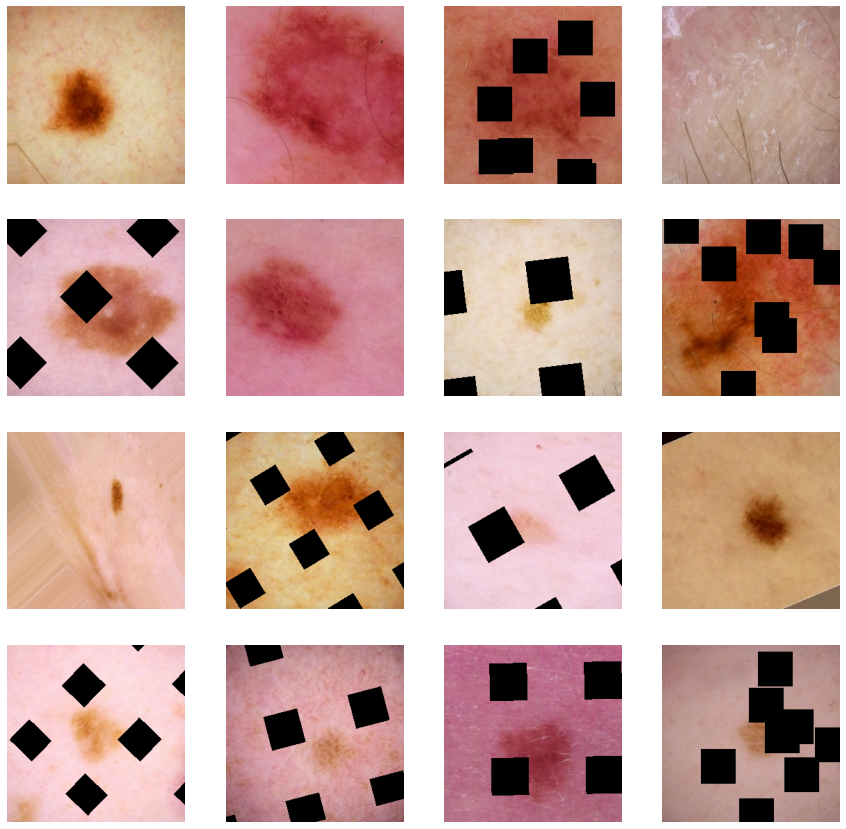

In [ ]:
#view what augmentation combination looks like
row = 4; col = 4;
row = min(row,BATCH_SIZE//col)
all_elements = get_dataset(train_files, labeled = True, grid_mask = False, all_aug = True,  
                           course_drop = False, shuffle = True, repeat = True)

for (img,label) in all_elements:
    plt.figure(figsize=(15,15))
    for j in range(16):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# IV. Model Training

**Now, it will take far too much time for us to train a model ourselves to learn the optimal weights for classifying our images, so we will instead import a model that has already been pre-trained on ImageNet: a large labeled dataset of real-world images**

**We will be importing several popular pre-trained models. For a list of all the pre-trained models that can be imported with `tf.keras`, see [here](https://keras.io/api/applications/)**

Learning rate schedule: 5e-06 to 4e-05 to 1.4e-05


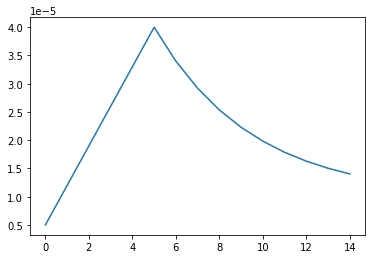

In [ ]:
#define epoch parameters
STEPS_PER_EPOCH = count_data_items(train_files) // BATCH_SIZE

#define learning rate parameters
LR_START = 5e-6
LR_MAX = 5e-6 * 8
LR_MIN = 1e-5
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_DECAY = .8

#define ramp up and decay
def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = True)

#visualize learning rate schedule
rng = [i for i in range(EPOCHS)]
y = [lr_schedule(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

**If you decide to use an EfficientNet model for your final model, you need to install something as it is not yet supported by `keras.applications`. There is another weight option for EffNets to consider that outperforms Imagenet weights called 'Noisy Student' that you can read about [here](https://arxiv.org/abs/1911.04252). For more on EffNets in general, read [this](https://arxiv.org/pdf/1905.11946.pdf)**

In [ ]:
#import DenseNet201, Xception, InceptionV3, and InceptionResNetV2
from tensorflow.keras.applications import DenseNet201, Xception, InceptionV3, InceptionResNetV2

#requirements to use EfficientNet(s)
!pip install -q efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 51kB 2.7MB/s 


In [ ]:
#helper function to create our model
def get_DenseNet201():
    with strategy.scope():
        dnet = DenseNet201(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        dnet.trainable = True
        model = tf.keras.Sequential([
            dnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model


#create Xception model
def get_Xception():
    with strategy.scope():
        xception = Xception(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        xception.trainable = True
        model = tf.keras.Sequential([
            xception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model

#create Inception model
def get_InceptionV3():
    with strategy.scope():
        inception = InceptionV3(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception.trainable = True
        model = tf.keras.Sequential([
            inception,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model


#create InceptionResNet model
def get_InceptionResNetV2():
    with strategy.scope():
        inception_res = InceptionResNetV2(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )
        #make trainable so we can fine-tune
        inception_res.trainable = True
        model = tf.keras.Sequential([
            inception_res,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model


#create EfficientNetB4 model
def get_EfficientNetB4():
    with strategy.scope():
        efficient = efn.EfficientNetB4(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model

#create EfficientNetB5 model
def get_EfficientNetB5():
    with strategy.scope():
        efficient = efn.EfficientNetB5(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt,loss = loss,metrics = ['AUC'])
    return model

#create EfficientNetB6 model
def get_EfficientNetB6():
    with strategy.scope():
        efficient = efn.EfficientNetB6(
            input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights = 'noisy-student', #or imagenet
            include_top = False
        )
        #make trainable so we can fine-tune
        efficient.trainable = True
        model = tf.keras.Sequential([
            efficient,
            tf.keras.layers.GlobalAveragePooling2D(),
            #tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation = 'sigmoid')
        ])
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05) 
    model.compile(optimizer = opt, loss = loss,metrics = ['AUC'])
    return model

**And now we train on 3 three folds. We will predict 'out-of-fold' so that we do not need to save model/model weights from each fold, only the predictions. If we were to try to store each model from the folds in memory and then predict with each model, we would get a memory error. So instead of this:**

In [ ]:
from sklearn.model_selection import KFold
#train and cross validate in folds

histories = []
preds = np.zeros((count_data_items(test_files),1))

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
kfold = KFold(FOLDS, shuffle = True, random_state = SEED)

for f,(train_index,val_index) in enumerate(kfold.split(np.arange(15))):
    
    #show fold info
    if DEVICE=='TPU':
        #hack to clear TPU memory
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('FOLD',f+1); print('#'*25)
    
    #create our file paths
    train_files = tf.io.gfile.glob([GCS_PATH+ '/train%.2i*.tfrec'%x for x in train_index])
    
    #now we upsample if we want
    if UPSAMPLE:
        train_files += tf.io.gfile.glob([GCS_PATH2 + '/train%.2i*.tfrec'%x for x in train_index])
    
    #shuffle for more randomness
    np.random.shuffle(train_files)
    
    #grab validation and test files
    val_files = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in val_index])
    test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    
    #convert files to datasets
    train_ds = get_dataset(train_files,labeled = True, return_image_names = False, all_aug = True,
                           mat_aug = False, course_drop = False, repeat = True, shuffle = True)

    val_ds = get_dataset(val_files, mat_aug = False, course_drop = False, all_aug = False, grid_mask = False,
                         repeat = False, shuffle = False, labeled = True, return_image_names = False)
    
    #define save callback based on loss
    sv = tf.keras.callbacks.ModelCheckpoint(
                            f'fold-{f}.h5', monitor = 'val_loss', verbose = 0, save_best_only = True,
                            save_weights_only = True, mode = 'min', save_freq = 'epoch')
   
    #and go!
    print('Training...'); print('')
    model = get_EfficientNetB4()
    history = model.fit(train_ds, validation_data = val_ds, callbacks = [sv, lr_callback],
                        verbose = VERBOSE, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS
    )
    
    histories.append(history)
    print('Loading best model...')
    model.load_weights(f'fold-{f}.h5')
    
    if TTA > 0:
        ds_test = get_dataset(test_files,labeled = False,return_image_names = False,mat_aug = True,
                              course_drop = False, repeat = True,shuffle = False)
        ct_test = count_data_items(test_files); STEPS = TTA * ct_test/BATCH_SIZE
        pred = model.predict(ds_test,steps = STEPS,verbose = VERBOSE)[:TTA*ct_test,] 
        preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order = 'F'),axis = 1) * 1 / FOLDS
      
    else:
        ds_test = get_dataset(test_files,labeled = False,return_image_names = False, mat_aug = False,
                              course_drop = False, repeat = False, shuffle = False)   
        pred = model.predict(ds_test,verbose = VERBOSE)
        preds += pred * 1 / FOLDS
     
    #so we don't hit memory limits
    del model; z = gc.collect()

INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 1
#########################
Training...

71680000/71678424 [==============================] - 1s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/15
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


127/127 - 109s - loss: 0.5894 - auc: 0.5198 - val_loss: 0.4743 - val_auc: 0.4845

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/15
127/127 - 86s - loss: 0.2384 - auc: 0.5044 - val_loss: 0.1851 - val_auc: 0.5385

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/15
127/127 - 87s - loss: 0.1784 - auc: 0.6036 - val_loss: 0.1710 - val_auc: 0.7742

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/15
127/127 - 87s - loss: 0.1724 - auc: 0.7328 - val_loss: 0.1694 - val_auc: 0.8374

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/15
127/127 - 87s - loss: 0.1711 - auc: 0.7830 - val_loss: 0.1688 - val_auc: 0.8494

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/15
127/127 - 88s - loss: 0.1692 - auc: 0.8032 - val_loss: 0.1673 - val_auc: 0.8701

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/15

644/643 - 78s


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 2
#########################
Training...


Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/15


127/127 - 110s - loss: 0.5796 - auc: 0.4951 - val_loss: 0.4728 - val_auc: 0.5357

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/15
127/127 - 88s - loss: 0.2253 - auc: 0.5093 - val_loss: 0.1830 - val_auc: 0.6059

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/15
127/127 - 87s - loss: 0.1770 - auc: 0.6312 - val_loss: 0.1700 - val_auc: 0.7786

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/15
127/127 - 87s - loss: 0.1725 - auc: 0.7283 - val_loss: 0.1681 - val_auc: 0.8356

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/15
127/127 - 87s - loss: 0.1710 - auc: 0.7690 - val_loss: 0.1673 - val_auc: 0.8525

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/15
127/127 - 87s - loss: 0.1699 - auc: 0.8022 - val_loss: 0.1660 - val_auc: 0.8750

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/15

644/643 - 79s


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 3
#########################
Training...


Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/15


127/127 - 110s - loss: 0.5186 - auc: 0.5337 - val_loss: 0.3915 - val_auc: 0.6132

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/15
127/127 - 87s - loss: 0.2224 - auc: 0.5297 - val_loss: 0.1822 - val_auc: 0.6189

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/15
127/127 - 87s - loss: 0.1763 - auc: 0.6674 - val_loss: 0.1700 - val_auc: 0.7918

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/15
127/127 - 87s - loss: 0.1726 - auc: 0.7315 - val_loss: 0.1690 - val_auc: 0.8234

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/15
127/127 - 87s - loss: 0.1705 - auc: 0.7777 - val_loss: 0.1680 - val_auc: 0.8400

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/15
127/127 - 87s - loss: 0.1692 - auc: 0.7979 - val_loss: 0.1673 - val_auc: 0.8505

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/15

644/643 - 79s


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 4
#########################
Training...


Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/15


127/127 - 112s - loss: 0.6293 - auc: 0.4768 - val_loss: 0.5033 - val_auc: 0.4253

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/15
127/127 - 87s - loss: 0.2279 - auc: 0.5014 - val_loss: 0.1836 - val_auc: 0.5765

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/15
127/127 - 88s - loss: 0.1765 - auc: 0.6077 - val_loss: 0.1708 - val_auc: 0.7568

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/15
127/127 - 87s - loss: 0.1739 - auc: 0.7305 - val_loss: 0.1692 - val_auc: 0.8121

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/15
127/127 - 87s - loss: 0.1695 - auc: 0.7758 - val_loss: 0.1688 - val_auc: 0.8272

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/15
127/127 - 87s - loss: 0.1695 - auc: 0.8151 - val_loss: 0.1682 - val_auc: 0.8357

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/15

644/643 - 79s


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.115.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


#########################
FOLD 5
#########################
Training...


Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/15


127/127 - 112s - loss: 0.5880 - auc: 0.5202 - val_loss: 0.4149 - val_auc: 0.5440

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2e-05.
Epoch 2/15
127/127 - 87s - loss: 0.2330 - auc: 0.5114 - val_loss: 0.1776 - val_auc: 0.6016

Epoch 00003: LearningRateScheduler reducing learning rate to 1.9e-05.
Epoch 3/15
127/127 - 87s - loss: 0.1769 - auc: 0.6343 - val_loss: 0.1703 - val_auc: 0.7454

Epoch 00004: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 4/15
127/127 - 92s - loss: 0.1733 - auc: 0.7482 - val_loss: 0.1691 - val_auc: 0.7995

Epoch 00005: LearningRateScheduler reducing learning rate to 3.3e-05.
Epoch 5/15
127/127 - 86s - loss: 0.1703 - auc: 0.7757 - val_loss: 0.1695 - val_auc: 0.8165

Epoch 00006: LearningRateScheduler reducing learning rate to 4e-05.
Epoch 6/15
127/127 - 88s - loss: 0.1701 - auc: 0.8029 - val_loss: 0.1681 - val_auc: 0.8296

Epoch 00007: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 7/15

644/643 - 79s


In [ ]:
#dummy test dataset to grab image names
ds = get_dataset(test_files, course_drop = False, repeat = False, mat_aug = False,
                 dim = IMAGE_SIZE[0], labeled = False, return_image_names = True)

#snag the image IDs
image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

#save to disk for submission
submission = pd.DataFrame(dict(image_name = image_names, target = preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index = False)

#sanity check
submission.head(10)

image_name    target
9905   ISIC_0052060  0.029630
1443   ISIC_0052349  0.024030
3120   ISIC_0058510  0.023930
4870   ISIC_0073313  0.024154
5494   ISIC_0073502  0.041334
4537   ISIC_0074618  0.039380
4819   ISIC_0076801  0.022427
7203   ISIC_0077586  0.077718
10897  ISIC_0082004  0.052006
5093   ISIC_0082785  0.055462

In [ ]:
#another sanity check
print(f"Predicted {len(submission[submission['target'] > .5])} images with melanoma")

Predicted 2 images with melanoma


In [ ]:
#define function to visualize learning curves
def plot_learning_curves(histories): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))
    
    #plot accuracies
    for i in range(0, 3):
        ax[0].plot(histories[i].history['auc'], color = 'C0')
        ax[0].plot(histories[i].history['val_auc'], color = 'C1')

    #plot losses
    for i in range(0, 3):
        ax[1].plot(histories[i].history['loss'], color = 'C0')
        ax[1].plot(histories[i].history['val_loss'], color = 'C1')

    #fix legend
    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper right')
    
    #set master titles
    fig.suptitle("Model Performance", fontsize=14)
    
    #label axis
    for i in range(0,2):
        ax[0].set_ylabel('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[1].set_ylabel('Loss')
        ax[1].set_xlabel('Epoch')

    return plt.show()

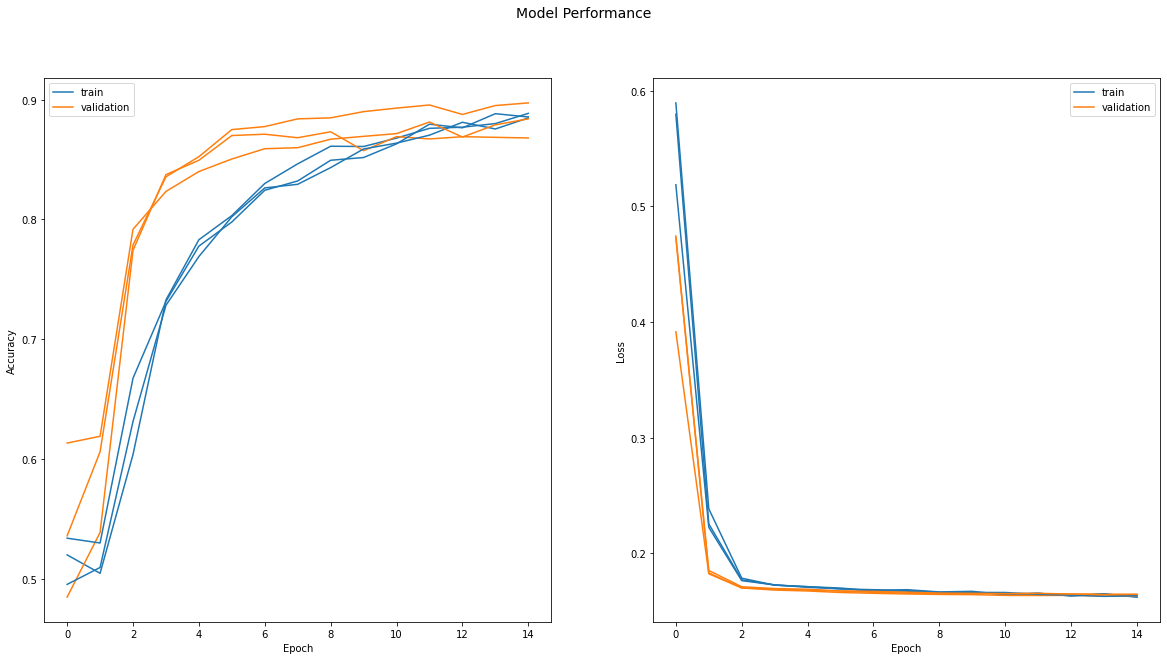

In [ ]:
plot_learning_curves(histories)

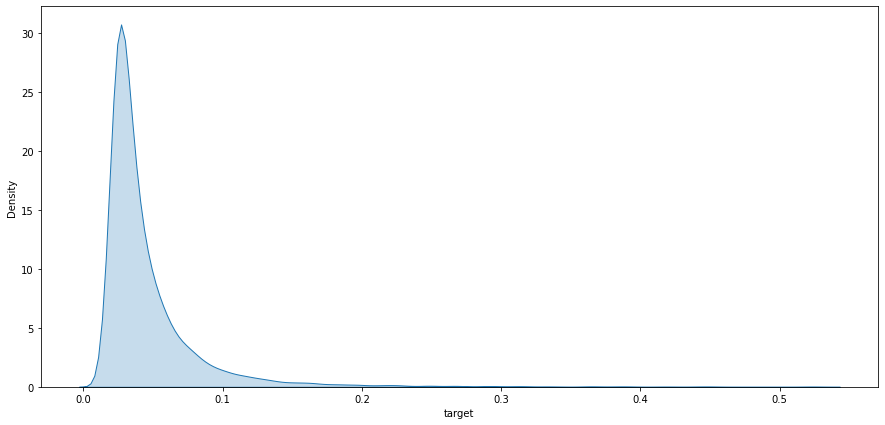

In [ ]:
#okay last sanity check
fig, ax = plt.subplots(figsize = (15, 7))
sns.kdeplot(submission.target, shade = True)
plt.show()